In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [ ]:
!pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
boneage = pd.read_csv("scaled_boneage.csv", index_col = 0)
boneage.head()

,id,boneage,male,1,2,3,4,5,6,7,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,1377,180,0,0.0,-1.560237,-0.583802,0.780311,0.221399,-0.937382,-0.987514,...,0.563162,0.365317,0.235397,0.326632,0.315830,-0.005371,-0.200495,-0.132342,-0.058859,0.0
1,1378,12,0,0.0,0.177853,0.203694,0.165015,0.103280,0.119956,0.177927,...,0.348038,0.233157,0.120522,-0.026721,-0.111723,-0.092013,-0.134275,-0.229009,-0.249066,0.0
2,1379,94,0,0.0,3.247461,5.522963,6.572581,3.883090,1.320475,0.286341,...,0.353959,0.235969,0.128180,-0.231294,-1.127160,-1.925179,-1.727442,-0.920785,-0.455393,0.0
3,1380,120,1,0.0,0.243920,0.697714,1.004606,0.096718,-1.043850,-1.276616,...,0.205937,-0.059281,-0.361955,-0.626492,0.004882,1.303382,1.236861,-0.077966,-0.751987,0.0
4,1381,82,0,0.0,0.088915,0.061847,0.052867,0.116404,0.175026,0.205031,...,0.375668,0.269712,0.147326,0.005824,-0.014552,0.003749,-0.079741,-0.162550,-0.174917,0.0


In [ ]:
boneage.shape

(12611, 1027)

In [ ]:
X, y = boneage.drop(["boneage", "id", "male"], axis=1), boneage[["boneage"]].values.flatten()
print(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

[  1   4   6   9  10  12  13  14  15  16  17  18  20  21  24  27  28  29
  30  32  33  34  36  37  38  39  40  42  43  45  46  48  49  50  51  52
  54  55  56  57  58  60  62  63  64  65  66  67  69  70  72  74  75  76
  77  78  80  81  82  84  86  87  88  90  91  93  94  96 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 120 121 123
 124 125 126 128 129 130 132 133 134 135 136 137 138 139 140 141 142 143
 144 146 147 148 149 150 151 152 153 154 156 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 176 177 179 180 182 183 184 186
 188 189 192 194 196 197 198 200 204 206 210 212 214 216 222 228]


In [ ]:
print(X_train.shape)

(2871, 1024)


In [ ]:
# # Encode the target to numeric
# y_encoded = pd.factorize(y)[0]
# print(y_encoded)

In [ ]:
%matplotlib inline
# pca = PCA(n_components = 0.90) # Original approach, reduced from 1024 dimensions to 74 
pca = PCA(n_components = 0.50)
pca.fit(X_train)
reduced_train = pca.transform(X_train)
print('Original Dimensions: ', X_train.shape)  
print('Reduced Dimensions: ', reduced_train.shape) 

Original Dimensions:  (8449, 1024)
Reduced Dimensions:  (8449, 11)


In [ ]:
print(pca.explained_variance_)

print(pca.explained_variance_ratio_)

[108.6480446   93.70664398  67.62152595  55.84774233  43.8844319
  34.0886303   31.68650236  27.10793099  24.05824172  20.99237891
  19.05853611]
[0.10552376 0.09101201 0.065677   0.05424178 0.04262249 0.03310838
 0.03077532 0.02632841 0.02336642 0.02038872 0.01851049]


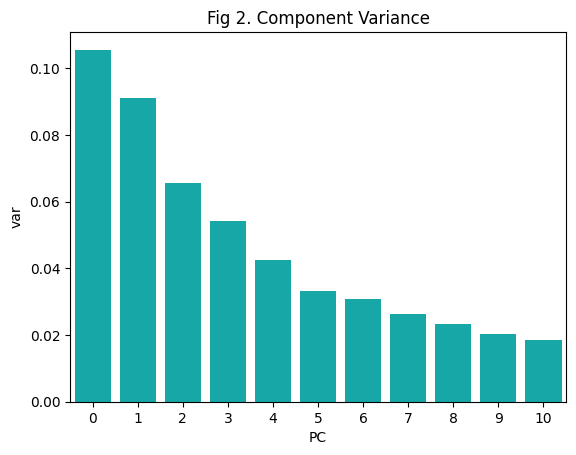

In [ ]:
import seaborn as sn
PC_strings = [str(i) for i in range(reduced_train.shape[1])]
dfScree = pd.DataFrame({'var':pca.explained_variance_ratio_,'PC':PC_strings})
sn.barplot(x='PC',y="var",data=dfScree, color="c").set_title('Fig 2. Component Variance');

In [ ]:
# df_pc = pd.DataFrame(data = reduced, columns = [str(i) for i in range(reduced.shape[1])])

# df_col = pd.concat([df_pc, boneage.drop(["boneage", "id", "male"], axis=1) ], axis=1)
# df_col
# covMatrix = pd.DataFrame.cov(df_col)
# sn.set(rc={'figure.figsize':(14,6)})
# sn.heatmap(covMatrix, annot=True, fmt='g')
# plt.figure(figsize=(28,18))
# plt.show()

In [ ]:
import gpytorch

# Create a GP model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
reduced_test = pca.transform(X_test)

In [ ]:
reduced_train = torch.tensor(reduced_train, dtype=torch.double)
y_train = torch.tensor(y_train, dtype=torch.double)
reduced_test = torch.tensor(reduced_test, dtype=torch.double)
y_test = torch.tensor(y_test, dtype=torch.double)

In [ ]:
# Create a Gaussian Process model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(reduced_train, y_train, likelihood)

In [ ]:
# Train the model
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
for i in range(100):
    optimizer.zero_grad()
    output = model(reduced_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()

In [ ]:
print(torch.tensor(reduced_test))
reduced_test.dtype

tensor([[  9.3223,  -1.5085,  -7.3323,  ...,   2.5471,   2.1829,  -1.8144],
        [  6.9543,   4.5051,  -2.4777,  ...,  -0.0232,  -4.4317,   3.4532],
        [-10.4033,   4.8028,  -6.4280,  ...,   0.5200,  -1.4755,  -1.0286],
        ...,
        [  1.6536,  -0.8808,   0.0872,  ...,  -0.6945,  -0.9649,   0.3620],
        [ -0.6805,  11.9796,  -4.8337,  ...,   5.8485,   7.3066,  -2.3775],
        [-19.2090,  -3.5622,   5.8461,  ...,  -1.2462,   3.0992,  -2.6841]],
       dtype=torch.float64)


<ipython-input-51-9010c64daab6>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(reduced_test))


torch.float64

In [ ]:
# Make predictions with uncertainty
model.eval()
likelihood.eval()
squared_errors = []
with torch.no_grad():
    output = model(reduced_test)
    prediction_mean = output.mean
    prediction_covar = output.covariance_matrix

In [ ]:
# Calculate mean squared error (MSE)
mse = torch.mean((prediction_mean - y_test) ** 2)
print("Mean Squared Error (MSE):", mse.item())

Mean Squared Error (MSE): 2314.342965762778


In [ ]:
# Define the tolerance range
tolerance = 10.0  # Adjust this value according to your desired range

# Check if each predicted value is within the tolerance range of the corresponding true value
within_range = torch.abs(prediction_mean - y_test) <= tolerance

error = 0
for i, value in enumerate(prediction_mean):
    # print(prediction_mean[i], y_test[i])
    if not within_range[i]:
      error += 1
# print("Total incorrect is", error, "resulting in an error percentage of", error/prediction_mean.size(0))
total = prediction_mean.size(0)
correct = total - error

k_quantile_value = np.percentile(mse.numpy(), 20)
rmse = np.sqrt(k_quantile_value)
accuracy = 100 * correct / total
print('RMSE ({}-quantile): {}'.format(20, rmse))
print('Test accuracy within +/- 10: {}/{} ({}%)'.format(correct, total, accuracy))

RMSE (20-quantile): 48.107618583367625
Test accuracy within +/- 10: 747/4162 (17.94810187409899%)
